<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/03_data_science_modules/03_winter_temperature_enso.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook examines the relationship between winter minimum temperatures in southern central IN and El Nino.

**Goal:** examine the relationship between El Nino and minimum winter (Dec-Jan-Feb) temperatures in Bloomington, IN

**Method:**

 * obtain minimum temperature data from [NOAA NClimDiv](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00005), using the *NCEI Direct Download* method
 * read the dataset using `pandas`, filter out data for southern central Indiana
 * convert the data to timeseries format
 * obtain the [ENSO longitude index](https://cascade.lbl.gov/enso-longitude-index-eli/) Excel file and read with `pandas`; convert to timeseries format
 * make the ENSO and NClimDiv timeseries align (same start and end dates, same period - DJF, etc)
 * plot both timeseries
 * plot a scatter plot
 * do linear regression and correlation analyses

For this solution notebook, I will be using data directly from NOAA instead of downloading it, since `pandas` has the ability to open data from a URL.

# Part 1: Getting the NClimDiv data

**Important:** Download this notebook and place it in your course folder, running it in Visual Studio Code (not Google Colab).  You'll commit this to your git repository at the end.

In [1]:
""" Import libraries """
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

In [2]:
""" Read the tmin data file. """
#filename = r"C:\Users\travi\Insync\obrienta@iu.edu\Google Drive - Shared drives\[Sec-E] BL-EAS-obrienta\teaching\2023 Grad Python Course\lessons\03_data_science_modules\climdiv-tmindv-v1.0.0-20230804"
file_url = "https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmindv-v1.0.0-20230804"

# set the header manually
header = ["code"]
header = header + list(range(1,13))

# read in the data file, 
climdiv_df = pd.read_csv(file_url, header = None, names = header, delimiter = "\s+", na_values = -99.9)
climdiv_df

,code,1,2,3,4,5,6,7,8,9,10,11,12
0,101281895,27.5,21.8,37.4,47.8,54.7,63.5,66.5,65.9,63.1,37.9,37.4,30.6
1,101281896,30.3,32.6,36.6,52.2,61.1,63.6,68.7,67.1,57.2,44.8,40.1,31.2
2,101281897,26.8,37.4,45.1,47.0,52.4,64.7,68.0,65.2,59.0,48.8,36.5,32.9
3,101281898,34.7,31.0,45.1,42.7,57.4,66.0,68.5,67.1,63.0,47.0,34.5,28.0
4,101281899,28.8,22.2,38.8,47.8,61.2,65.1,66.9,68.3,56.8,50.7,40.3,28.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45658,5013282019,28.7,32.9,29.9,32.3,36.6,43.9,48.0,50.4,46.3,38.4,34.1,27.0
45659,5013282020,18.5,26.0,27.3,33.0,36.9,42.7,47.5,47.3,42.3,37.5,31.6,25.1
45660,5013282021,24.3,30.1,26.8,31.6,36.5,42.2,46.3,47.6,43.3,36.0,25.3,31.1
45661,5013282022,24.2,28.6,26.3,30.4,34.3,42.1,45.3,46.9,44.2,37.3,33.3,29.4


In [3]:
""" Filter out south central Indiana. """

# set the state and division code
statecode = "12" # Indiana
divcode = "08" # South Central division
state_div = statecode + divcode

# get the rows that are in the requested climate division
code_as_str = climdiv_df['code'].astype(str).str # convert the code column to a string
in_div = code_as_str.startswith(state_div) # search the code column for entries starting with 1208

# select only those rows using boolean indexing
scin_df = climdiv_df[in_div]

scin_df



,code,1,2,3,4,5,6,7,8,9,10,11,12
10707,1208281895,14.5,11.1,28.5,42.8,50.1,61.6,61.8,62.1,56.9,33.6,31.6,25.8
10708,1208281896,22.8,23.5,26.5,47.8,56.6,59.7,64.9,62.1,52.8,37.7,34.4,27.0
10709,1208281897,17.8,25.4,33.3,40.8,45.1,58.4,65.6,60.3,53.6,45.3,32.6,25.8
10710,1208281898,26.0,23.8,36.2,38.8,53.1,61.5,64.9,63.9,58.8,45.0,28.8,20.6
10711,1208281899,20.7,12.7,29.4,43.9,55.1,62.8,63.0,64.4,53.1,46.5,36.1,21.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10831,1208282019,22.8,27.4,29.6,42.8,55.4,60.0,65.6,62.3,59.6,44.9,28.0,29.4
10832,1208282020,29.3,27.6,38.2,39.1,50.2,60.3,66.3,62.1,54.3,43.4,36.4,26.4
10833,1208282021,25.4,19.6,35.6,41.0,49.0,62.2,64.7,65.0,57.2,51.3,29.4,33.3
10834,1208282022,17.5,22.9,34.1,40.7,54.5,60.3,66.4,62.9,54.9,39.9,33.5,26.1


<Axes: xlabel='date'>

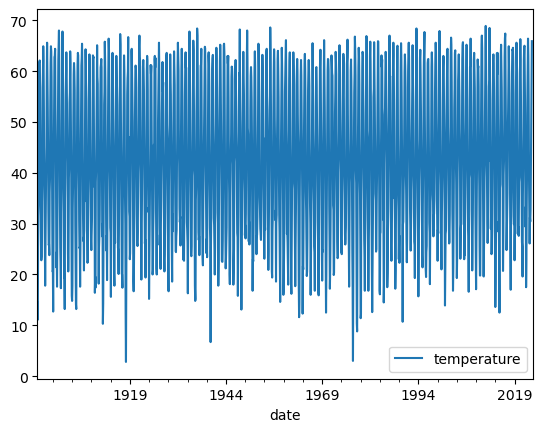

In [4]:
""" Convert the dataset to a timeseries. """
# convert to a numpy array
scin_as_numpy = scin_df.values
# pull out only the temperature data
scin_temp_np = scin_as_numpy[:,1:13]

# convert the matrix to a vector
scin_temps = scin_temp_np.ravel()

# make dates for each index
scin_dates = pd.date_range(start = '1895-01-1', end = '2024-01-01', freq = '1M')

# create a new dataframe for the timeseries
dataframe_dict = {'date' : scin_dates, 'temperature' : scin_temps}
scin_ts = pd.DataFrame(dataframe_dict)
scin_ts.plot('date', 'temperature')

C:\Users\travi\AppData\Local\Temp\ipykernel_10544\4185795996.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scin_ts_winter_avg = scin_ts_winter.groupby(year).mean()


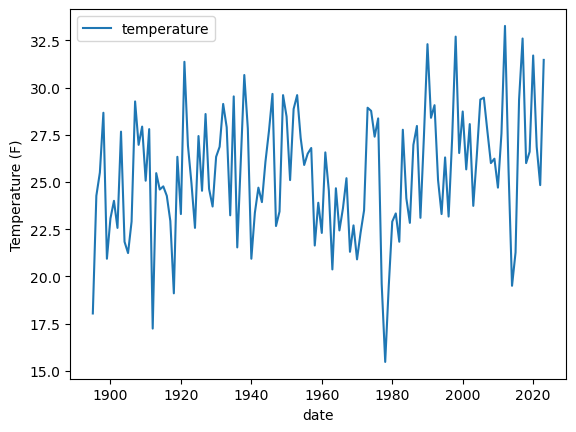

In [5]:
""" Select and average over winter times (DJF). """

# select only the winter months
date_month_values = scin_ts['date'].dt.month # get the month values for each date
in_winter = date_month_values.isin([1,2,3])
# use boolean indexing to select only the winter months
scin_ts_winter = scin_ts[in_winter]

# group by year and average over the winter months
year = scin_ts_winter['date'].dt.year # pull out the year for each date
scin_ts_winter_avg = scin_ts_winter.groupby(year).mean()

# plot the timeseries
fig, ax = plt.subplots()
scin_ts_winter_avg.plot(ax = ax)
ax.set_ylabel("Temperature (F)")
plt.show()

# Part 2: Reading and opening El Nino data

In [6]:
# set the URL to the ELI file
eli_url = "https://portal.nersc.gov/archive/home/projects/cascade/www/ELI/ELI_ERSSTv5_1854.01-2020.05.xlsx"

# read in the data
eli_df = pd.read_excel(eli_url, sheet_name = "ELI_ERSSTv5_1854.01-2020.02", header = 0, skiprows = 0)
eli_df

,Unnamed: 0,1854,1855,1856,1857,1858,1859,1860,1861,1862,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Jan,158.62,156.95,163.24,151.52,164.42,158.76,156.20,159.05,155.27,...,150.93,152.95,155.70,157.64,160.75,175.10,155.08,154.20,160.23,158.67
1,Feb,159.30,159.96,158.84,154.36,167.38,154.50,153.08,178.75,156.26,...,150.42,153.97,154.62,157.65,160.22,172.86,156.50,154.15,163.96,158.26
2,Mar,154.63,155.97,158.07,150.68,154.81,157.37,161.36,172.58,159.08,...,146.19,153.88,147.89,158.11,161.58,164.78,158.90,151.16,161.35,155.82
3,Apr,154.60,154.78,150.77,147.31,162.29,154.51,152.08,151.74,151.58,...,146.99,158.13,148.63,154.01,164.81,155.91,156.11,152.29,157.37,152.13
4,May,160.56,159.68,157.31,157.18,163.30,155.67,155.39,153.93,154.05,...,148.74,151.82,157.76,157.77,167.87,160.95,157.20,157.35,161.7,154.51
5,Jun,167.42,164.79,160.78,175.59,166.08,159.56,168.50,158.09,161.82,...,160.46,163.68,163.07,168.99,179.12,162.99,166.31,163.56,169.81,NaN
6,Jul,171.27,169.29,164.36,170.79,168.07,172.13,174.46,162.12,163.93,...,165.15,171.93,165.38,172.30,182.31,162.86,167.77,167.36,170.99,NaN
7,Aug,170.06,164.72,162.23,168.05,165.31,171.72,168.99,168.20,167.53,...,163.99,170.16,165.98,170.86,182.46,160.89,165.69,167.66,169.55,NaN
8,Sep,167.25,170.77,157.28,171.20,163.19,166.94,160.77,167.22,172.79,...,162.47,167.07,164.86,168.46,181.57,159.52,165.12,165.77,167.04,NaN
9,Oct,162.51,171.23,163.08,167.59,163.84,165.18,157.49,158.13,169.94,...,158.79,164.63,161.79,164.21,179.94,156.15,161.67,165.35,164.16,NaN


hint: use the `merge()` method in pandas to get the ELI and NOAA data to align.